The second edition of *Think DSP* is not for sale yet, but if you would like to support this project, you can [buy me a coffee](https://buymeacoffee.com/allendowney).

# Saxophone

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkDSP2/blob/main/examples/saxophone.ipynb).

In [1]:
import importlib, sys
sys.modules["imp"] = importlib

%load_ext autoreload
%autoreload 2

In [2]:
# download thinkdsp.py

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ThinkDSP2/raw/main/soln/thinkdsp.py")

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from thinkdsp import decorate

## The case of the missing fundamental

This notebook investigates autocorrelation, pitch perception and a phenomenon called the "missing fundamental".

I'll start with a recording of a saxophone.

In [4]:
# download saxophone.wav

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
        
download("https://github.com/AllenDowney/ThinkDSP/raw/master/code/100475__iluppai__saxophone-weep.wav")

In [5]:
from thinkdsp import read_wave

wave = read_wave('100475__iluppai__saxophone-weep.wav')
wave.normalize()
wave.make_audio()

The spectrogram shows the harmonic structure over time.

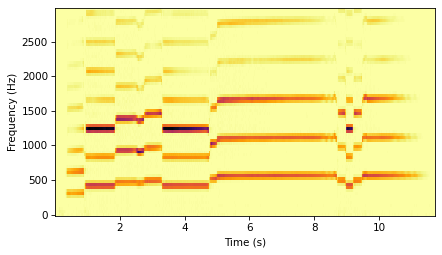

In [6]:
gram = wave.make_spectrogram(seg_length=1024)
gram.plot(high=3000)
decorate(xlabel='Time (s)', ylabel='Frequency (Hz)')

To see the harmonics more clearly, I'll take a segment near the 2 second mark and compute its spectrum.

In [7]:
start = 2.0
duration = 0.5
segment = wave.segment(start=start, duration=duration)
segment.make_audio()

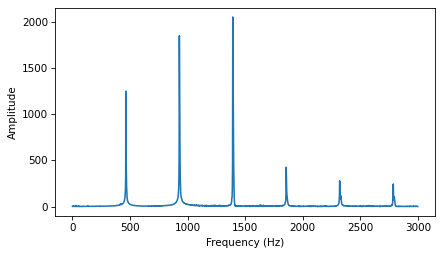

In [8]:
spectrum = segment.make_spectrum()
spectrum.plot(high=3000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

The peaks in the spectrum are at 1392, 928, and 464 Hz.

In [9]:
spectrum.peaks()[:10]

[(2054.0622639591206, 1392.0),
 (1850.8544230639038, 928.0),
 (1684.8468845494765, 1394.0),
 (1332.8150506072802, 930.0),
 (1249.1774991462646, 464.0),
 (1177.6718910227576, 1396.0),
 (857.3729096557306, 932.0),
 (742.841588837269, 1398.0),
 (515.1804113061312, 934.0),
 (513.7226300908811, 466.0)]

The pitch we perceive is the fundamental, at 464 Hz, even though it is not the dominant frequency.

For comparison, here's a triangle wave at 464 Hz.

In [10]:
from thinkdsp import TriangleSignal

TriangleSignal(freq=464).make_wave(duration=0.5).make_audio()

And here's the segment again.

In [11]:
segment.make_audio()

They have the same perceived pitch.

To understand why we perceive the fundamental frequency, even though it is not dominant, it helps to look at the autocorrelation function (ACF).

The following function computes the ACF, selects the second half (which corresponds to positive lags) and normalizes the results:

In [12]:
def autocorr(segment):
    corrs = np.correlate(segment.ys, segment.ys, mode='same')
    N = len(corrs)
    lengths = range(N, N//2, -1)

    half = corrs[N//2:].copy()
    half /= lengths
    half /= half[0]
    return half

And here's what the result:

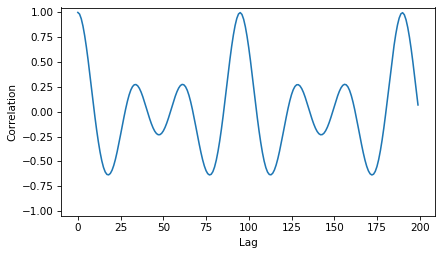

In [13]:
corrs = autocorr(segment)
plt.plot(corrs[:200])
decorate(xlabel='Lag', ylabel='Correlation', ylim=[-1.05, 1.05])

The first major peak is near lag 100.

The following function finds the highest correlation in a given range of lags and returns the corresponding frequency.

In [14]:
def find_frequency(corrs, low, high):
    lag = np.array(corrs[low:high]).argmax() + low
    print(lag)
    period = lag / segment.framerate
    frequency = 1 / period
    return frequency

The highest peak is at a lag 95, which corresponds to frequency 464 Hz.

In [15]:
find_frequency(corrs, 80, 100)

95


464.2105263157895

At least in this example, the pitch we perceive corresponds to the highest peak in the autocorrelation function (ACF) rather than the highest component of the spectrum.

Surprisingly, the perceived pitch doesn't change if we remove the fundamental completely.  Here's what the spectrum looks like if we use a high-pass filter to clobber the fundamental.

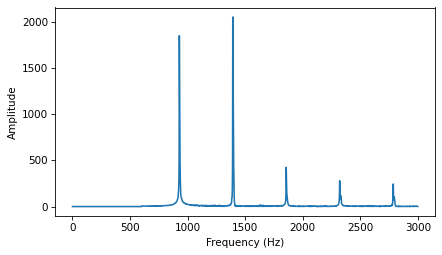

In [16]:
spectrum2 = segment.make_spectrum()
spectrum2.high_pass(600)
spectrum2.plot(high=3000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

And here's what it sounds like.

In [17]:
segment2 = spectrum2.make_wave()
segment2.make_audio()

The perceived pitch is still 464 Hz, even though there is no power at that frequency.  This phenomenon is called the "missing fundamental": https://en.wikipedia.org/wiki/Missing_fundamental

To understand why we hear a frequency that's not in the signal, it helps to look at the autocorrelation function (ACF).

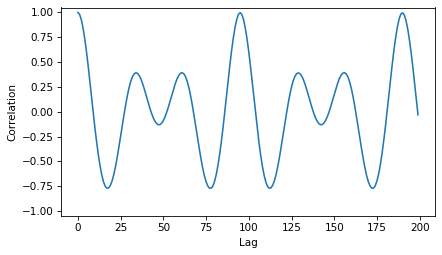

In [18]:
corrs = autocorr(segment2)
plt.plot(corrs[:200])
decorate(xlabel='Lag', ylabel='Correlation', ylim=[-1.05, 1.05])

The third peak, which corresponds to 464 Hz, is still the highest:

In [19]:
find_frequency(corrs, 80, 100)

95


464.2105263157895

But there are two other peaks corresponding to 1297 Hz and 722 Hz.  

In [20]:
find_frequency(corrs, 20, 50)

34


1297.0588235294117

In [21]:
find_frequency(corrs, 50, 80)

61


722.9508196721312

So why don't we perceive either of those pitches, instead of 464 Hz?  The reason is that the higher components that are present in the signal are harmonics of 464 Hz and they are not harmonics of 722 or 1297 Hz.

Our ear interprets the high harmonics as evidence that the "right" fundamental is at 464 Hz.

If we get rid of the high harmonics, the effect goes away.  Here's a spectrum with harmonics above 1200 Hz removed.

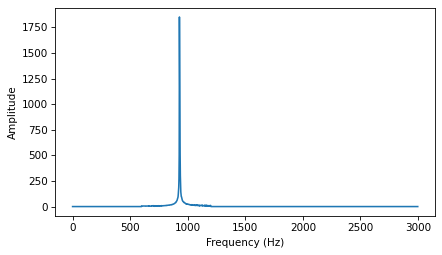

In [22]:
spectrum4 = segment.make_spectrum()
spectrum4.high_pass(600)
spectrum4.low_pass(1200)
spectrum4.plot(high=3000)
decorate(xlabel='Frequency (Hz)', ylabel='Amplitude')

Now the perceived pitch is 928 Hz.

In [23]:
segment4 = spectrum4.make_wave()
segment4.make_audio()

In [24]:
TriangleSignal(freq=928).make_wave(duration=0.5).make_audio()

And if we look at the autocorrelation function, we find the highest peak at lag=47, which corresponds to 938 Hz.

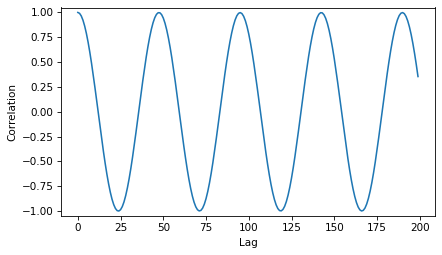

In [25]:
corrs = autocorr(segment4)
plt.plot(corrs[:200])
decorate(xlabel='Lag', ylabel='Correlation', ylim=[-1.05, 1.05])

In [26]:
find_frequency(corrs, 30, 50)

47


938.2978723404256

For convenience, here are all the versions together.

A triangle signal at 464 Hz:

In [27]:
TriangleSignal(freq=464).make_wave(duration=0.5).make_audio()

The original segment:

In [28]:
segment.make_audio()

After removing the fundamental:

In [29]:
segment2.make_audio()

After removing the harmonics above the dominant frequency, too.

In [30]:
segment4.make_audio()

And a pure sinusoid:

In [31]:
from thinkdsp import SinSignal

SinSignal(freq=928).make_wave(duration=0.5).make_audio()

In summary, these experiments suggest that pitch perception is not based entirely on spectral analysis, but is also informed by something like autocorrelation.

[Think DSP: Digital Signal Processing in Python, 2nd Edition](https://allendowney.github.io/ThinkDSP2/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)